## plotting synoptic maps and frames with python

In this notebook, we will plot synoptic maps, derived from vector magnetic magnetic field data taken with the NASA Solar Dynamics Observatory (SDO) Helioseismic and Magnetic Imager (HMI) instrument, to look exactly like the [synoptic maps](http://hmi.stanford.edu/data/synoptic.html) generated by the HMI team. <br>

A *synoptic map* shows the entire Sun throughout a Carrington rotation. To construct this, we take a column of data from the central meridian of every vector magnetic field map observed within a Carrington rotation and stack them together horizontally. As such, these diachronic synoptic maps are represented in the Carrington coordinate system using a Cylindrical Equal-Area projection. Synoptic maps can be calculated from both line-of-sight and vector magnetic field data. [Liu et al. (2017)](http://adsabs.harvard.edu/abs/2017SoPh..292...29L) computed synoptic maps for all vector magnetic field data taken with HMI since 2010.<br>

A *synoptic frame* is similar in concept, but replaces the first 120&deg; latitude swath of data in the synoptic map with synchronic data from a single magnetogram. This method does not blur out quickly-evolving photospheric features.  

In [1]:
import json, requests, numpy as np, matplotlib.pylab as plt, math, drms, sunpy.map
import matplotlib.colors as mcol
from astropy.io import fits
from datetime import datetime as dt_obj
from datetime import timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
%matplotlib inline
%config InlineBackend.figure_format='retina'

### synoptic map

We'll use the [drms](https://drms.readthedocs.io/en/stable/) library to read boththe metadata and image data. The HMI synoptic chart data is computed using C [modules](http://jsoc.stanford.edu/cvs/JSOC/proj/mag/synop/apps/) that takes the JSOC Data Record Managment System (DRMS) series [hmi.M_720s](http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.M_720s) as an input. <br> 

In [2]:
c = drms.Client()

In [3]:
keys, segments = c.query('hmi.B_synoptic[$]', key='CAR_ROT,CUNIT1,CUNIT2,LON_FRST,LON_LAST,T_START,T_STOP', seg='Br')
url = 'http://jsoc.stanford.edu' + segments.Br[0]
br = fits.open(url)
print("The file is for Carrington Rotation "+str(keys.CAR_ROT[0])+".")

The file is for Carrington Rotation 2216.


To label the axes correctly, we need to know the value of `CUNIT1` and `CUNIT2`, which are the units of the x and y dimensions, respectively.

In [4]:
print('CUNIT1 is in',keys.CUNIT1[0],".")
print('CUNIT2 is in',keys.CUNIT2[0],".")

CUNIT1 is in degree .
CUNIT2 is in Sine Latitude .


From `CUNIT1` we understand that the units of longitude are in degrees. [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T) says: "At the start of each Carrington rotation, L<sub>0</sub> [the Carrington Longitude] = 360&deg; and steadily decreases until it reaches L<sub>0</sub> = 0&deg;." Thus time in this synoptic map is represented from right to left -- i.e. the beginning of the Carrington period is at 360&deg; and the end of the Carrington period is at 0&deg;. <br>

From `CUNIT2` we understand that the units of latitude are in the sine of the angle. This is a convenient measure because in the Carrington Cylindrical Equal Area projection, "latitude pixels are equally spaced in the sine of the angle." (See [Thompson (2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T); Section 5.5). However we can also plot straight latitude, although the pixel size will not be the same across all latitudes:

In [5]:
ytick_latitude = []
ytick_normalize = []
for i in range(19):
    calculation = math.sin((np.pi/18)*(i-9.0))
    ytick_latitude.append(calculation)
    ytick_normalize.append((calculation+1)*720.)

Now we can figure out which dates of the month this particular Carrington rotation corresponds to, and label the synoptic chart accordingly. <br>
To convert the keyword `T_REC` into a datetime object, we can use the function below.

In [6]:
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    if top: return dt_obj(year,month,day,0,0)
    else: return year,month,day,hour,minute

In [7]:
t_start = parse_tai_string(keys.T_START[0],datetime=True)
t_stop = parse_tai_string(keys.T_STOP[0],datetime=True)
delta_time = t_stop - t_start
print("This map spans",str(delta_time.days),"days between",str(t_start),"and",str(t_stop),".")

This map spans 27 days between 2019-04-08 19:12:00 and 2019-05-06 01:18:00 .


We need to label each date at the top of the date, i.e. YYYY-MM-DD_00:00:00.

In [8]:
t_top = dt_obj(t_start.year, t_start.month, t_start.day, 0, 0)
seconds_to_top_of_day = int((t_start - t_top).seconds)
seconds_per_pixel = int(delta_time.total_seconds() / 3600.)
pixels_to_top_of_day = seconds_to_top_of_day / seconds_per_pixel
xtick_locations = []
xtick_values = []
tmp = []
for i in range(int(delta_time.days)): 
    time_values = t_stop - timedelta(days=i)
    xtick_values.append(time_values.strftime('%d'))
    xtick_locations.append((int(math.ceil(i*1440/int(delta_time.days))))+pixels_to_top_of_day)
    tmp.append((int(math.ceil(i*1440/int(delta_time.days))))+0)

Now we can plot:

In [9]:
# load the color map
colors = np.loadtxt('HMI_MagColor_256.txt')
colormap_customized = mcol.ListedColormap(colors)

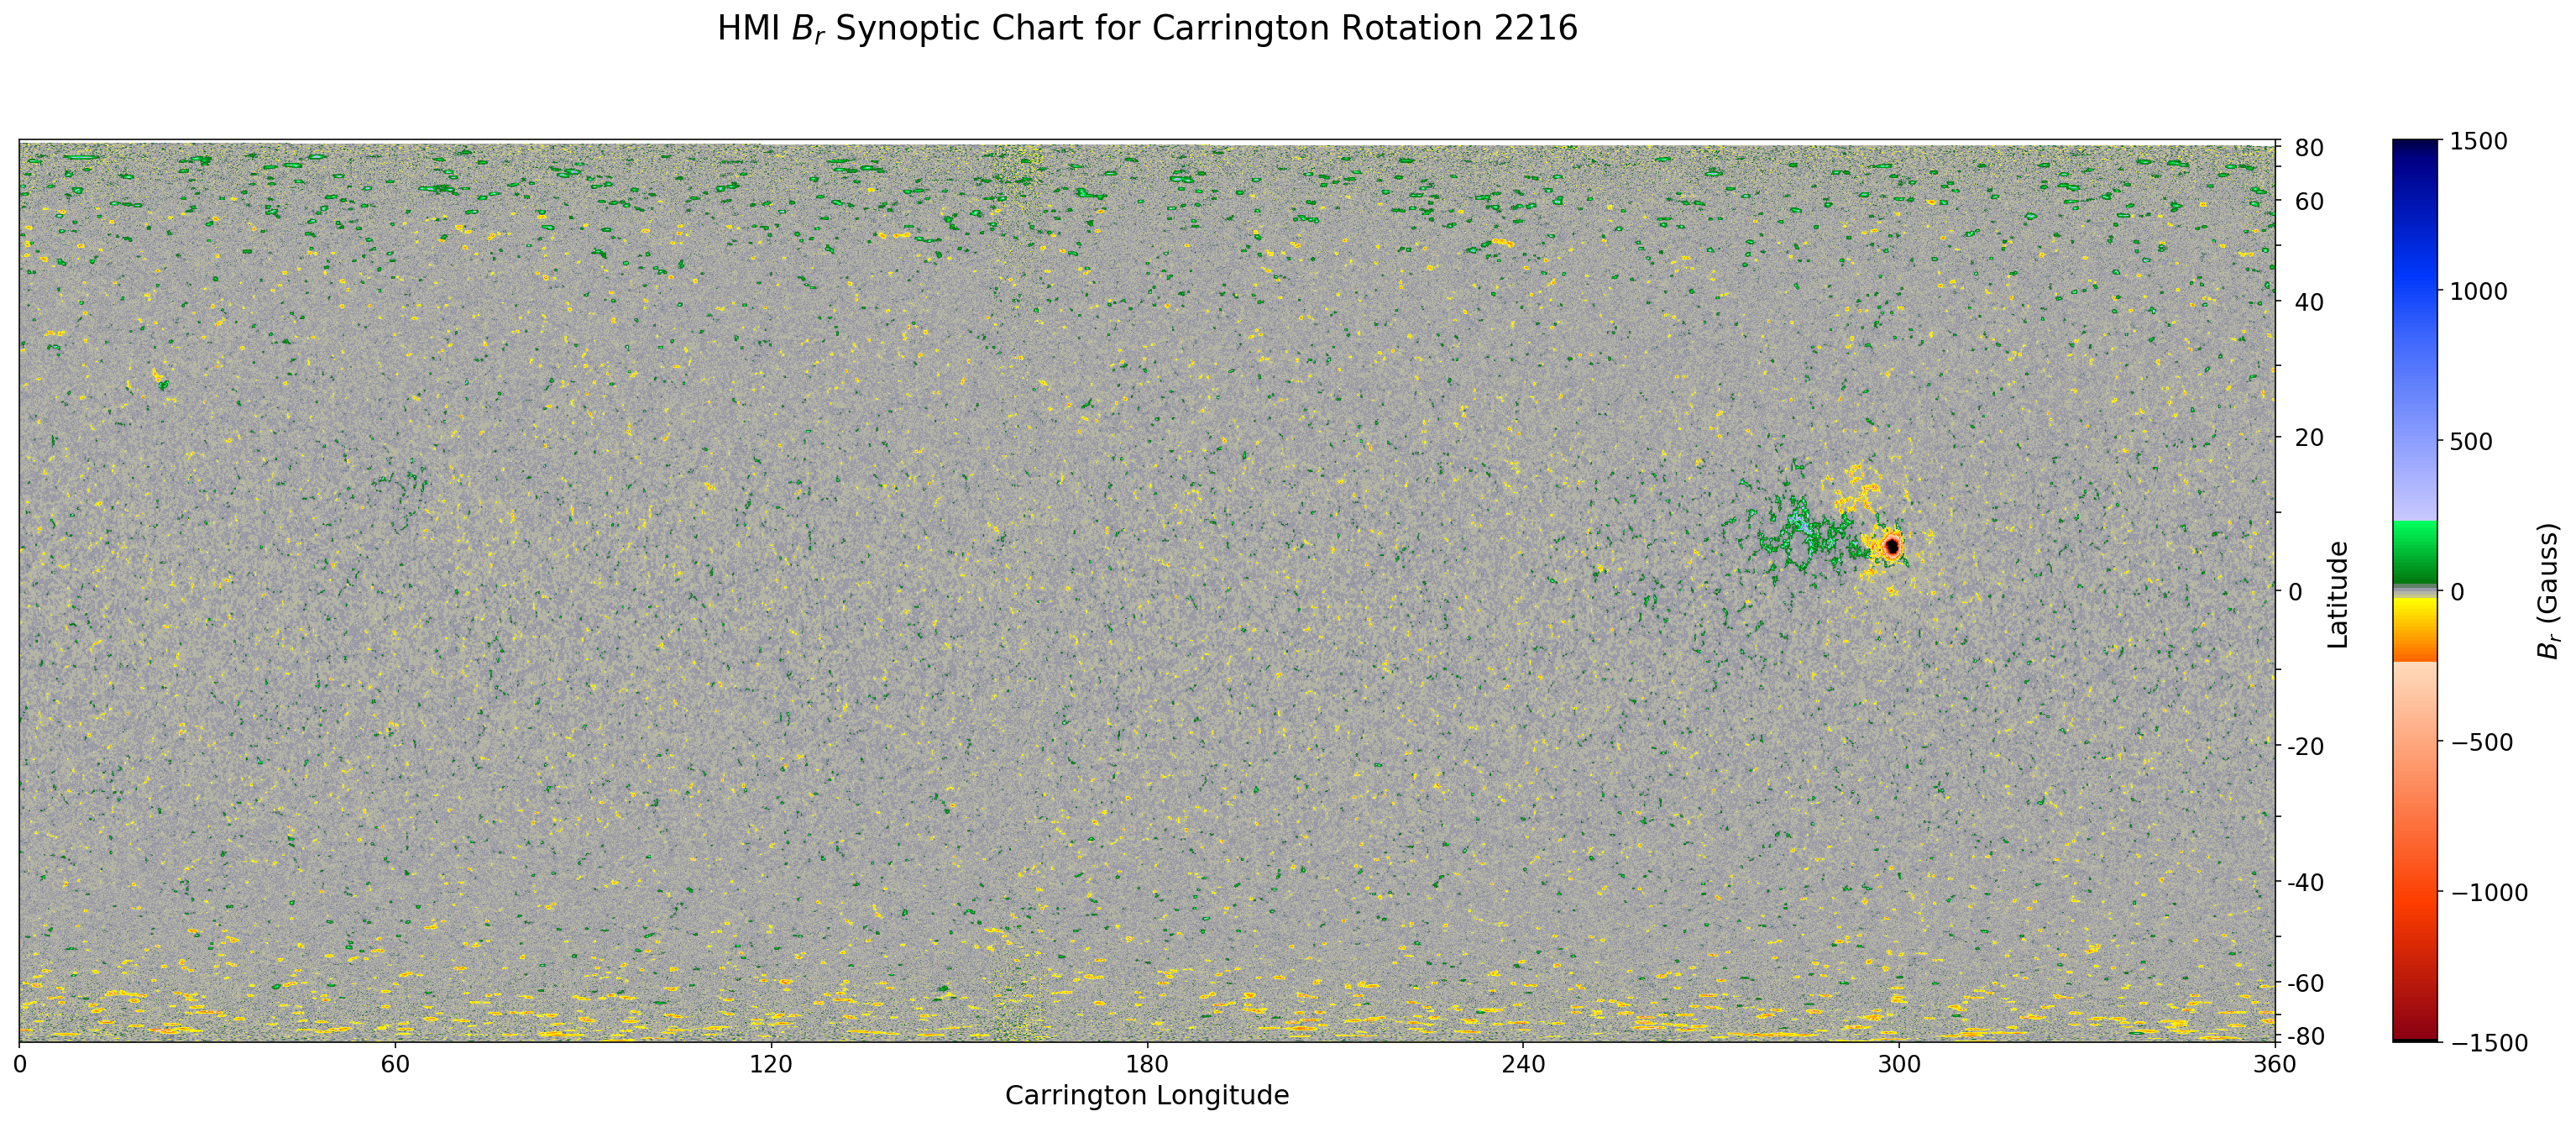

In [10]:
# make the plot
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
text_style = dict(fontsize=16)
ax.tick_params(labelsize=14)
plt.imshow(br[0].data,cmap=colormap_customized,vmin=-1500,vmax=1500,origin='lower',extent=[0,3600,0,1440],interpolation='nearest')
ax.set_title('HMI $B_{r}$ Synoptic Chart for Carrington Rotation '+str(keys.CAR_ROT[0]),y=1.1,fontsize=20)
ax.tick_params(axis='both', which='both', labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# label the x-axis 
xlabels = [0,60,120,180,240,300,360]
xlocations = [0,600,1200,1800,2400,3000,3600]
ax.set_xticklabels(xlabels)
ax.set_xticks(xlocations)
ax.set_xlabel('Carrington Longitude',**text_style)

# Create the latitude labels on the right-hand side of the plot
ylabels_r = [' ','-80 ',' ','-60',' ','-40',' ','-20',' ','0',' ',' 20',' ',' 40',' ',' 60',' ',' 80',' ']
ylocations_r = ytick_normalize
ax.set_yticklabels(ylabels_r)
ax.set_yticks(ylocations_r)
ax.set_ylabel('Latitude',**text_style)
ax.yaxis.labelpad=-5
ax.tick_params(labelsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# plot the colorbar
divider_cbar = make_axes_locatable(ax)
width_cbar = axes_size.AxesY(ax, aspect=0.05)
pad_cbar = axes_size.Fraction(2.6, width_cbar)
cax = divider_cbar.append_axes("right", size=width_cbar, pad=pad_cbar)
cax.tick_params(labelsize=14)
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$B_{r}$ (Gauss)', size=16)

# Create a new axes, ax3, to label the left-hand y-axis and the top x-axis
# This requires guess-and-check.
# This is not an elegant solution, but it is the best one I found. 
# The problem is that the twinx() function does not work well with imshow() because 
# the twinx() function creates an axes with dimensions of the entire figure, whereas 
# I just want the plotted area. If anyone has a better solution, please let me know.
# pos = ax.get_position() 
# ax3 = fig.add_axes([pos.x0,pos.y0+(0.126),pos.width-(0.067),pos.height-(0.253)])
# ax3.tick_params(labelsize=14)

# Create the sine latitude labels on the left-hand side of the plot
# ylabels_l = [-1,0,1]
# ylocations_l = [0.,720.,1440.]
# ax3.set_yticklabels(ylabels_l)
# ax3.set_yticks(ylocations_l)
# ax3.set_ylabel('Sine Latitude',**text_style)

# Create the date labels on the top of the plot
# ax3.set_xticklabels(xtick_values)
# ax3.set_xticks(xtick_locations)
# ax3.set_xlabel('From '+t_start.strftime('%B %-d %Y')+" to "+t_stop.strftime('%B %-d %Y'),**text_style)
# ax3.xaxis.labelpad=15
# ax3.xaxis.set_label_position("top")
# ax3.xaxis.tick_top()

### synoptic frame

We can make the same plots for synoptic frames. At the moment, the HMI team is only producing synoptic frames with line-of-sight magnetic field data. We plan to release this data product using vector magnetic field data imminently.

In [12]:
keys, segments = c.query('hmi.Mrdailysynframe_720s[$]', key='CAR_ROT,CUNIT1,CUNIT2,LON_FRST,LON_LAST,T_REC', seg='data')
url = 'http://jsoc.stanford.edu' + segments.data[0]
br = fits.open(url)
print("The file is for Carrington Rotation "+str(keys.CAR_ROT[0])+" at "+str(keys.T_REC[0])+".")

The file is for Carrington Rotation 2216 at 2019.05.03_12:00:00_TAI.


In [13]:
# Determine the starting and ending Carrington longitude 
start_lon   = ((math.floor(keys.LON_FRST[0]/360.)+1)*360.)-keys.LON_FRST[0]
end_lon     = ((math.floor(keys.LON_LAST[0]/360.)+1)*360.)-keys.LON_LAST[0]

# Determine the starting and ending Carrington rotation number
start_num   = math.floor(keys.LON_FRST[0]/360.)+1
end_num     = math.floor(keys.LON_LAST[0]/360.)+1

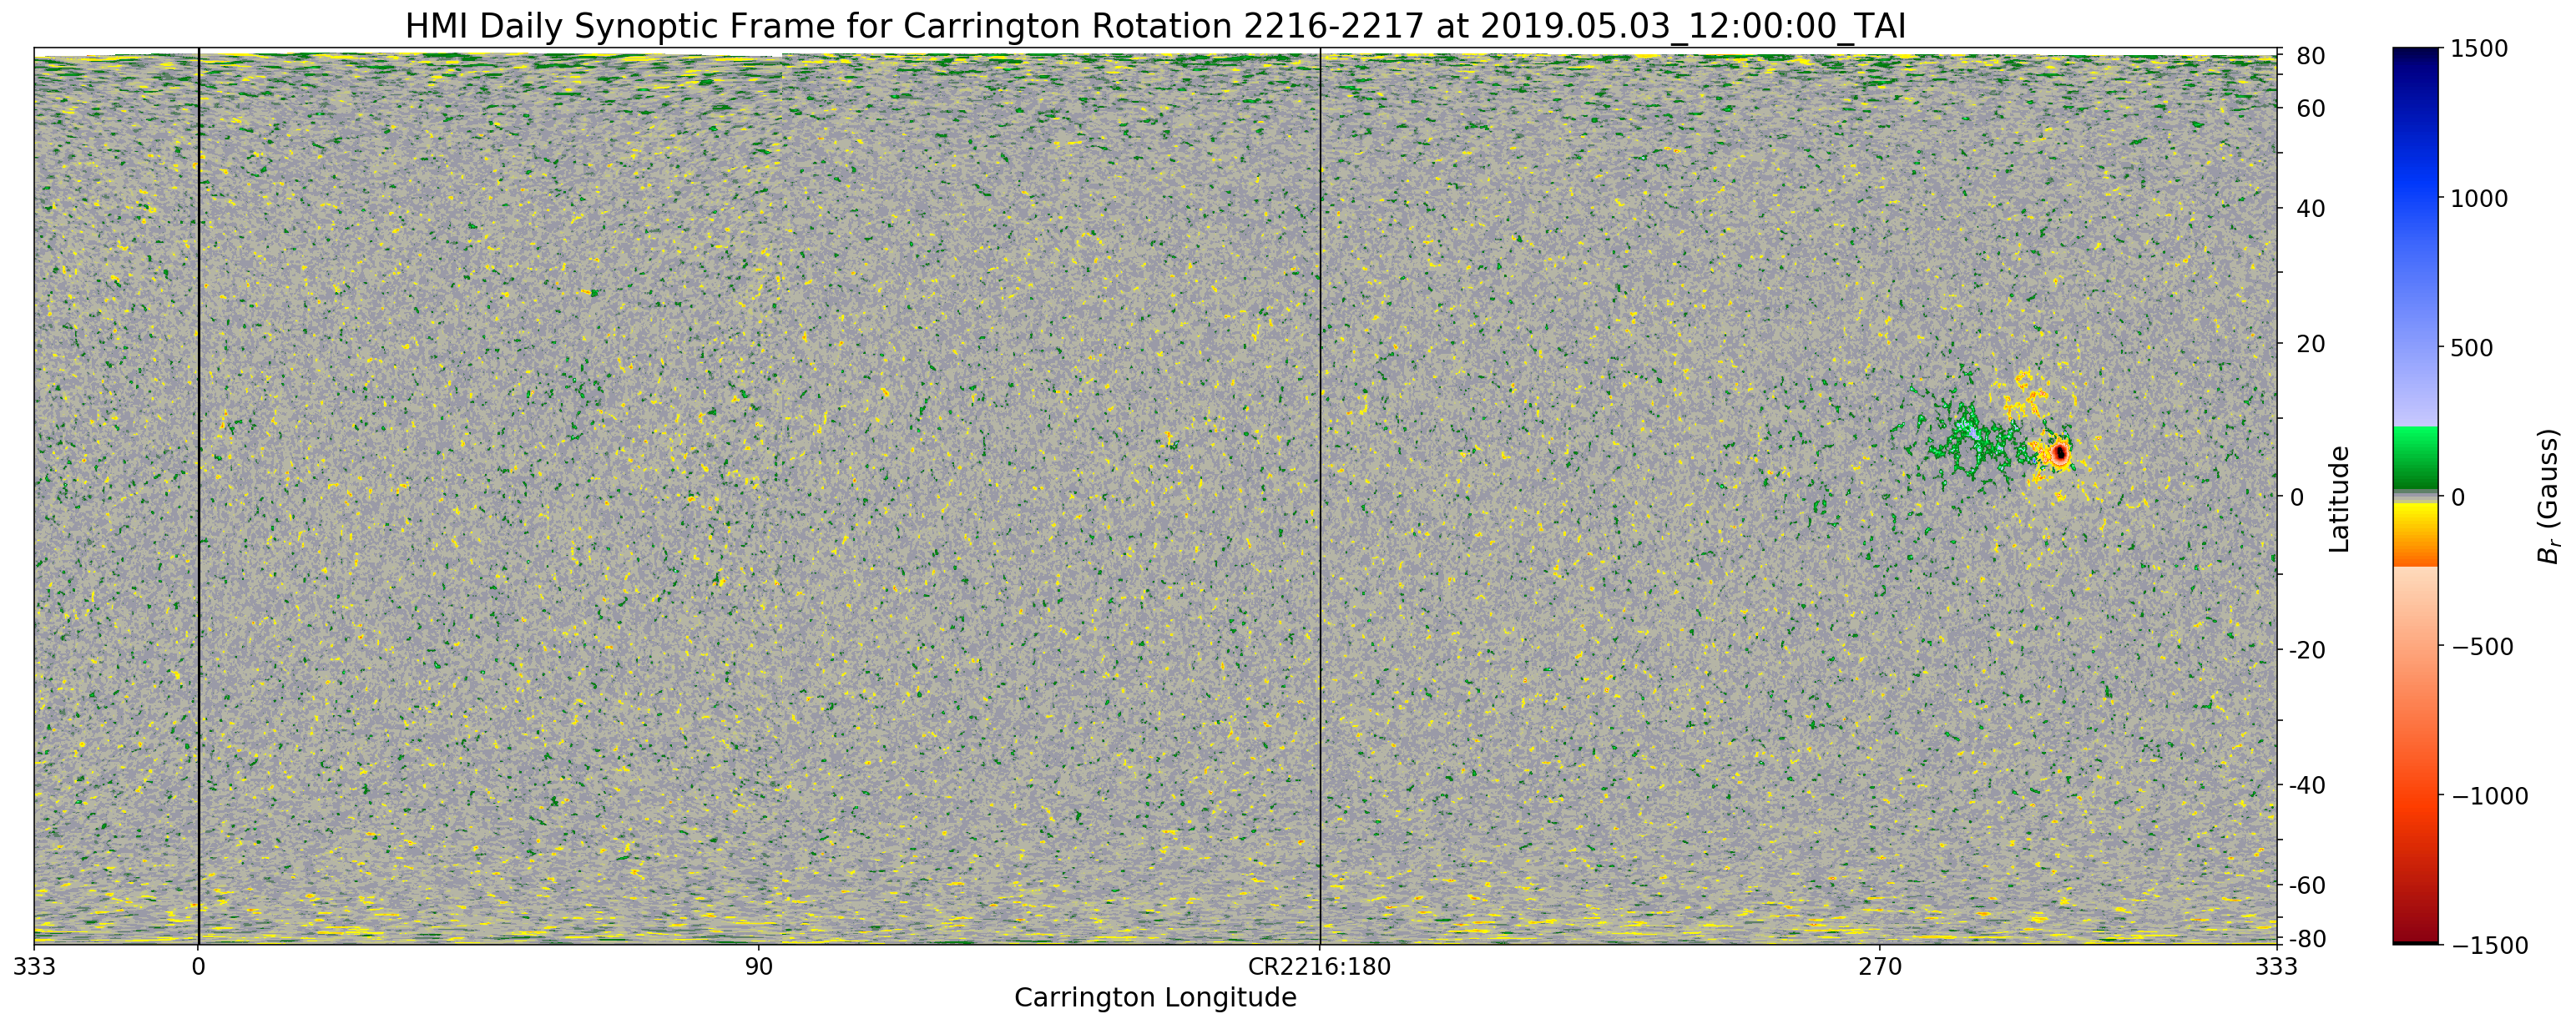

In [14]:
# calculate position of the longitudes at 0, 180, 90, and 270 as well as the first and last longitude
# and create 3-pixel thick vertical lines at 0 and 180
line_0 = (360. - start_lon)*10
line_180 = ((360. - start_lon + 180.) % 360)*10
line_plus90 = ((360. - start_lon + 90.) % 360)*10
line_minus90 = ((360. - start_lon + 270) % 360)*10
zero_lat = np.zeros([1440])
br[0].data[0:1440,int(line_0):int(line_0)+3] = -2000
br[0].data[0:1440,int(line_180):int(line_180)+3] = -2000

# make the plot
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
text_style = dict(fontsize=16)
ax.tick_params(labelsize=14)
plt.imshow(br[0].data,cmap=colormap_customized,vmin=-1500,vmax=1500,origin='lower',extent=[0,3600,0,1440],interpolation='nearest')
ax.set_title('HMI Daily Synoptic Frame for Carrington Rotation '+str(int(start_num))+"-"+str(int(end_num))+" at "+str(keys.T_REC[0]),y=1.0,fontsize=20)
ax.tick_params(axis='both', which='both', labelbottom=True, labeltop=False, labelleft=True, labelright=True)

# label the x-axis 
xlocations = [0,line_0,line_180,line_plus90,line_minus90,3600]
xlabels = [int(start_lon),0,"CR"+str(keys.CAR_ROT[0])+":180",90,270,int(end_lon)]
ax.set_xticklabels(xlabels)
ax.set_xticks(xlocations)
ax.set_xlabel('Carrington Longitude',**text_style)

# Create the latitude labels on the right-hand side of the plot
ylabels_r = [' ','-80 ',' ','-60',' ','-40',' ','-20',' ','0',' ',' 20',' ',' 40',' ',' 60',' ',' 80',' ']
ylocations_r = ytick_normalize
ax.set_yticklabels(ylabels_r)
ax.set_yticks(ylocations_r)
ax.set_ylabel('Latitude',**text_style)
ax.yaxis.labelpad=-5
ax.tick_params(labelsize=14)
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# plot the colorbar
divider_cbar = make_axes_locatable(ax)
width_cbar = axes_size.AxesY(ax, aspect=0.05)
pad_cbar = axes_size.Fraction(2.6, width_cbar)
cax = divider_cbar.append_axes("right", size=width_cbar, pad=pad_cbar)
cax.tick_params(labelsize=14)
cbar = plt.colorbar(cax=cax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$B_{r}$ (Gauss)', size=16)

# Create a new axes, ax3, to label the left-hand y-axis and the top x-axis
# This requires guess-and-check.
# This is not an elegant solution, but it is the best one I found. 
# The problem is that the twinx() function does not work well with imshow() because 
# the twinx() function creates an axes with dimensions of the entire figure, whereas 
# I just want the plotted area. If anyone has a better solution, please let me know.
# pos = ax.get_position() 
# ax3 = fig.add_axes([pos.x0,pos.y0+(0.126),pos.width-(0.067),pos.height-(0.253)])
# ax3.tick_params(labelsize=14)

# Create the sine latitude labels on the left-hand side of the plot
# ylabels_l = [-1,0,1]
# ylocations_l = [0.,720.,1440.]
# ax3.set_yticklabels(ylabels_l)
# ax3.set_yticks(ylocations_l)
# ax3.set_ylabel('Sine Latitude',**text_style)

# Create the date labels on the top of the plot
# ax3.set_xticklabels([''])
# ax3.set_xticks([''])